In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, q_stat
from statsmodels.tsa.tsatools import detrend
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

from sklearn.metrics import r2_score, mean_absolute_error, f1_score

In [12]:
%%capture
# uncomment if you are using Google Colab
# !gdown 1VeHncErg3tUA6pMggMwAG3Bg0-GwOFe0

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1VpS-RWsszdv6lRnI03ogl7zcm-UU7rKp/export?format=csv&ouid=109353123672021623729&rtpof=true&sd=true'
df = pd.read_csv(url)
df

,дата,направление,выход
0,30.12.2021,ш,"78,95"
1,29.12.2021,ш,"79,3"
2,28.12.2021,ш,"79,21"
3,27.12.2021,ш,"79,06"
4,24.12.2021,л,"78,69"
...,...,...,...
996,11.01.2018,л,"69,86"
997,10.01.2018,ш,"69,15"
998,09.01.2018,ш,"69,06"
999,05.01.2018,л,"68,78"


**Исходные данные расположены в обратном порядке, а прогноз нам нужно делать с 03.01.2022 по 31.03.2022 (48 значений)**

**Будем валидироваться на последних 48 значениях**

**Развернём данные и заберём часть на валидацию**

In [3]:
df = df.iloc[::-1].reset_index()
df.drop('index', axis=1, inplace=True)
df_train = df.iloc[:-48]
df_val = df.iloc[-48:]

In [4]:
print(len(df_train))
df_train

953


,дата,направление,выход
0,04.01.2018,ш,"67,67"
1,05.01.2018,л,"68,78"
2,09.01.2018,ш,"69,06"
3,10.01.2018,ш,"69,15"
4,11.01.2018,л,"69,86"
...,...,...,...
948,18.10.2021,л,"85,1"
949,19.10.2021,ш,"85,84"
950,20.10.2021,ш,"84,73"
951,21.10.2021,ш,"85,87"


In [5]:
print(len(df_val))
df_val

48


,дата,направление,выход
953,25.10.2021,л,"86,22"
954,26.10.2021,ш,"84,13"
955,27.10.2021,ш,"84,54"
956,28.10.2021,ш,"84,41"
957,29.10.2021,ш,"84,59"
958,01.11.2021,л,"84,23"
959,02.11.2021,ш,"81,29"
960,03.11.2021,л,"82,66"
961,05.11.2021,л,"83,68"
962,08.11.2021,л,"84,89"


In [6]:
df_train_output = df_train['выход'].apply(lambda x: x.replace(',', '.')).astype(float)
df_val_output = df_val['выход'].apply(lambda x: x.replace(',', '.')).astype(float)

df_train_direction = df_train['направление'].apply(lambda x: 1 if x == 'л' else 0)
df_val_direction = df_val['направление'].apply(lambda x: 1 if x == 'л' else 0)

In [7]:
def plotting(dataframe, title, figsize: tuple, window=None, mean=True, std=True):
    length = len(dataframe)
    x_values = np.arange(length)

    plt.figure(figsize=figsize)
    plt.plot(x_values, dataframe, linewidth=1, color='mediumblue', label='Data')
    fontsize=min(sum(figsize + figsize)-2, 16)

    if window:
        if mean:
            rolling_mean = dataframe.rolling(window=window).mean()
            plt.plot(rolling_mean, linewidth=1, color='r', label='Rolling mean')

        if std:
            rolling_std = dataframe.rolling(window=window).std()
            plt.plot(rolling_std,linewidth=1, color='darkgreen', label='Rolling std')

    plt.legend(loc='best', fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2, weight='bold')

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(axis='y', alpha=0.6)
    plt.show()

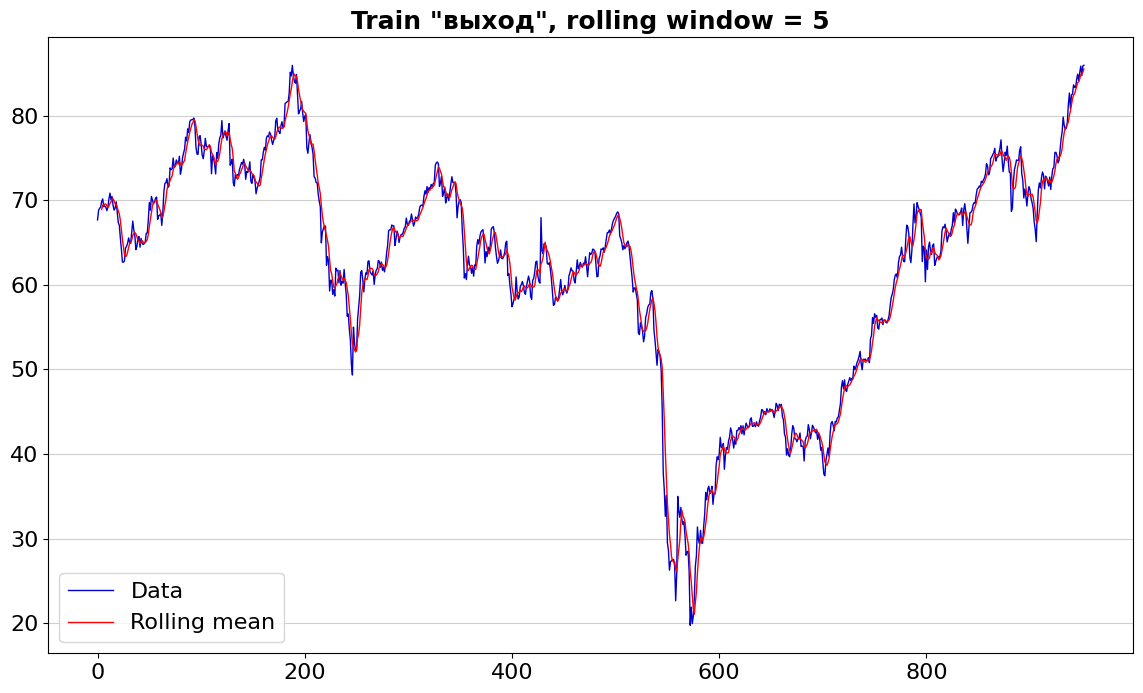

In [8]:
window = 5
plotting(df_train_output, f'Train "выход", rolling window = {window}', (14, 8), window, std=False)

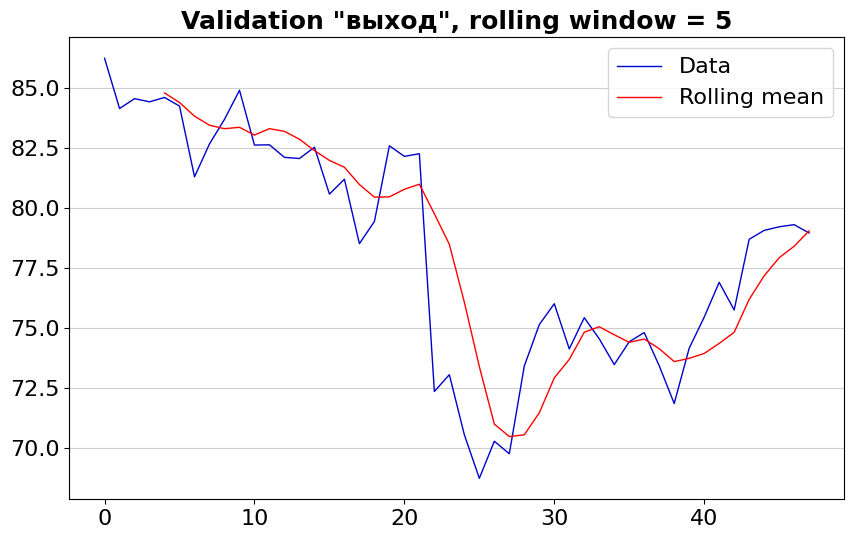

In [9]:
window = 5
plotting(df_val_output.reset_index().drop('index', axis=1), f'Validation "выход", rolling window = {window}', (10, 6), window, std=False)

# Статистические тесты

**Ряд похож на нестационарный. Проведём тесты**

In [10]:
def adf_test(time_series, maxlag=None, regression='c'):
    result = adfuller(time_series, maxlag=maxlag, regression=regression)
    print('ADF statistic: ', result[0])
    print('p-value: ', result[1])
    print('cricital values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[0] < result[4]['5%']:
        print('H_0 отвергнута: временной ряд является стационарным')
    else:
        print('H_0 не отвергнута: временной ряд является нестационарным')
    return result

def kpss_test(time_series, regression='c', nlags='auto'):
    '''
    The null hypothesis for the KPSS test.
    'c' : The data is stationary around a constant (default).
    'ct' : The data is stationary around a trend.
    '''
    result = kpss(time_series, regression=regression, nlags=nlags)
    print('KPSS statistic: ', result[0])
    print('p-value: ', result[1])
    print('cricital values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value}')
    if result[0] > result[3]['5%']:
        print('H_0 отвергнута: временной ряд является нестационарным')
    else:
        print('H_0 не отвергнута: временной ряд является стационарным')
    return result

| **тест ADF** | **тест KPSS** |
| :--- | :--- |
| $H_0$ : временной ряд является нестационарным | $H_0$ : временной ряд является стационарным |
| - могут быть единичные корни | - может быть стационарный тренд |
| - DSP не отвергается | - TSP не отвергается |
| $H_A$ : временной ряд является стационарным | $H_A$ : временной ряд является нестационарным |
| - ряд не имеет единичных корней | - не имеет стационарного тренда |
| - может быть стационарный тренд | - могут быть единичные корни |
| - DSP отвергается | - TSP отвергается |

Интерпретация:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

[источник](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

Если в тесте p-value < 0.05, мы отвергаем нулевую гипотезу

картинкa [отсюда](https://www.bsu.by/upload/page/546923.pdf)

(-0.5, 1004.5, 753.5, -0.5)

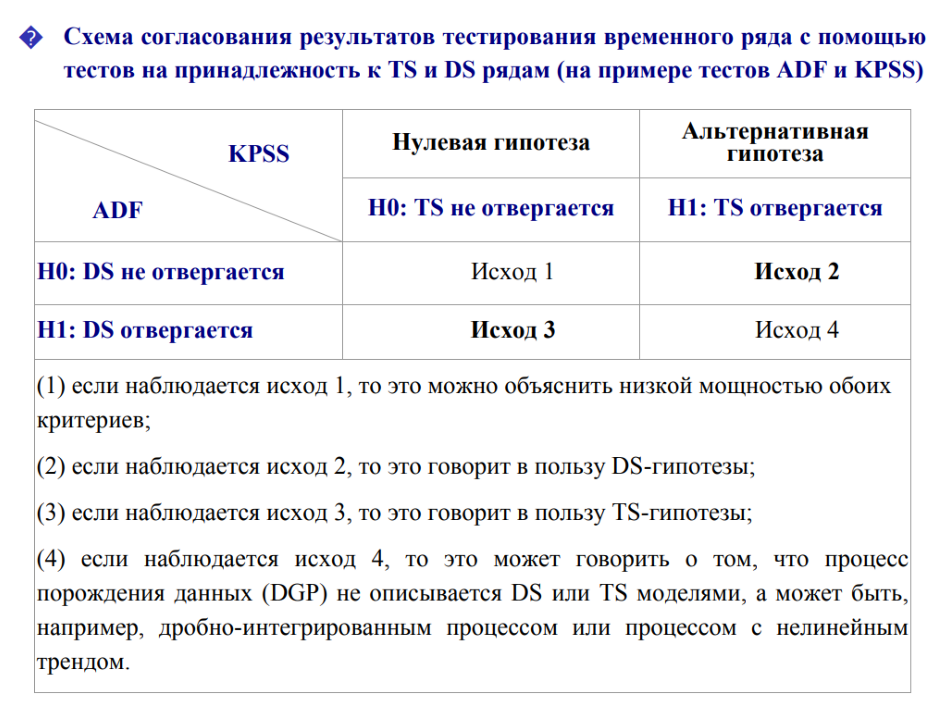

In [13]:
plt.figure(figsize=(12, 10))
image = plt.imread('adf-kpss.PNG')
plt.imshow(image)
plt.axis('off')

In [14]:
# регрессия с константой
regression = 'c'

result_adf = adf_test(df_train_output, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(df_train_output, regression=regression)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -1.0621047369416
p-value:  0.7299451885936818
cricital values:
	1%: -3.437237626048241
	5%: -2.8645807475403657
	10%: -2.56838906578808
H_0 не отвергнута: временной ряд является нестационарным
adf (-1.0621047369416, 0.7299451885936818, 0, 952, {'1%': -3.437237626048241, '5%': -2.8645807475403657, '10%': -2.56838906578808}, 3198.634353924308)

KPSS statistic:  1.1570014213233182
p-value:  0.01
cricital values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
H_0 отвергнута: временной ряд является нестационарным
kpss (1.1570014213233182, 0.01, 19, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})



<ipython-input-10-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


In [15]:
# регрессия с константой и трендом
regression = 'ct'

result_adf = adf_test(df_train_output, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(df_train_output, regression=regression)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -0.7450842657812563
p-value:  0.970010552688994
cricital values:
	1%: -3.96831108126977
	5%: -3.415111787459577
	10%: -3.1297703231017446
H_0 не отвергнута: временной ряд является нестационарным
adf (-0.7450842657812563, 0.970010552688994, 0, 952, {'1%': -3.96831108126977, '5%': -3.415111787459577, '10%': -3.1297703231017446}, 3199.7697666623526)

KPSS statistic:  0.6724655058735612
p-value:  0.01
cricital values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
H_0 отвергнута: временной ряд является нестационарным
kpss (0.6724655058735612, 0.01, 19, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})



<ipython-input-10-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


- ADF-тесты не отвергли $H_0$ --> ряд нестационарный, DSP не отвергается
- KPSS-тесты вернули p-value < 0.05, $H_0$ отвергается --> ряд нестационарный, TSP отвергается

**Ряд является DSP процессом**

может быть приведён к стационарному с помощью применения разностного оператора

# Коррелограммы

In [16]:
def correlogram_plotting(correlogram, time_series, nlags, figsize: tuple):
    # calculating
    if correlogram == 'acf':
        corr_values = acf(time_series, nlags=nlags)
        title = 'Sample ACF'
        ylabel = 'Sample Autocorrelation'
    elif correlogram == 'pacf':
        corr_values = pacf(time_series, nlags=nlags)
        title = 'Sample PACF'
        ylabel = 'Sample Partial Autocorrelation'

    x_ = np.arange(0, nlags+1)
    pos_interval = 1.96/np.sqrt(len(time_series))
    neg_interval = -1.96/np.sqrt(len(time_series))

    plt.figure(figsize=figsize)
    linewidth = 2
    markersize = figsize[0] * figsize[1]

    # vertical lines with markers
    plt.vlines(x_, ymin=0, ymax=corr_values, linewidth=linewidth, color='red')
    plt.scatter(x_, corr_values, s=markersize, color='red')

    # horizontal lines
    plt.hlines(0, xmin=-1, xmax=nlags+1, linewidth=1, color='black')
    plt.hlines(pos_interval, xmin=-1, xmax=nlags+1, linewidth=1, color='blue')
    plt.hlines(neg_interval, xmin=-1, xmax=nlags+1, linewidth=1, color='blue')

    # formatting and details
    plt.xlim(-1, nlags+1)
    plt.title(title, fontsize=sum(figsize), weight='bold')
    plt.xlabel('Lag', fontsize=sum(figsize)-2)
    plt.ylabel(ylabel, fontsize=sum(figsize)-2)
    plt.xticks(x_, fontsize=sum(figsize)-2)
    plt.yticks(fontsize=sum(figsize)-2)
    plt.grid(alpha=0.4)
    plt.show()

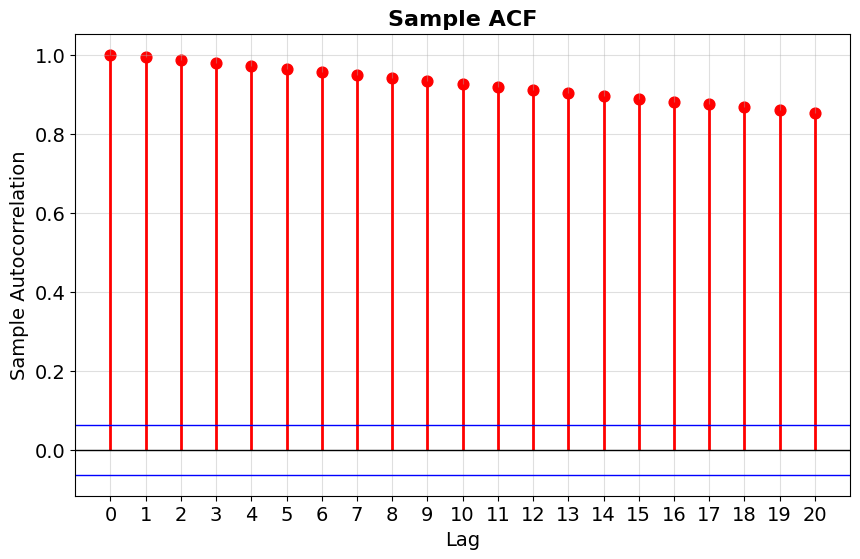

In [33]:
correlogram_plotting('acf', df_train_output, nlags=20, figsize=(10, 6))

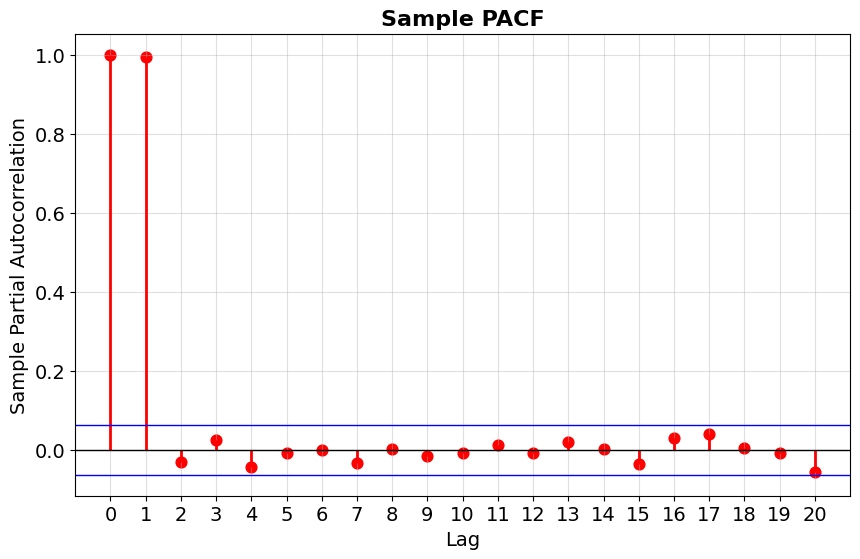

In [34]:
correlogram_plotting('pacf', df_train_output, nlags=20, figsize=(10, 6))

# Подбор моделей

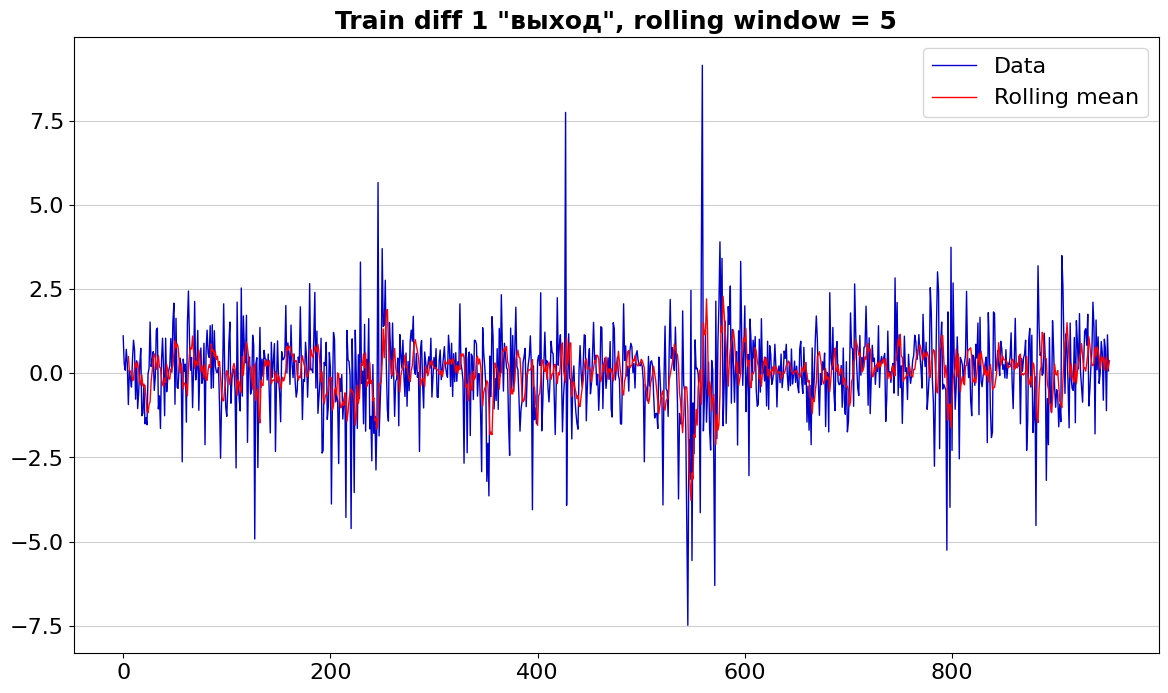

0.019191176470588232


In [39]:
df_train_d_1 = df_train_output.diff(periods=1).dropna()
window = 5
plotting(df_train_d_1, f'Train diff 1 "выход", rolling window = {window}', (14, 8), window, std=False)
print(df_train_d_1.mean())

**Посмотрим на равенство средних значений на разных интервалах**

In [58]:
step = len(df_train_d_1) // 5
parts = [df_train_d_1[:step], df_train_d_1[step:2*step], df_train_d_1[2*step:3*step], df_train_d_1[3*step:4*step], df_train_d_1[4*step:]]

for element in parts:
    for elem in parts:
        r1 = DescrStatsW(element)
        r2 = DescrStatsW(elem)
        print('p-value = %.4f' % CompareMeans(r1,r2).ttest_ind()[1], end='\t')
    print()

p-value = 1.0000	p-value = 0.1621	p-value = 0.0462	p-value = 0.6201	p-value = 0.5680	
p-value = 0.1621	p-value = 1.0000	p-value = 0.4862	p-value = 0.0733	p-value = 0.0718	
p-value = 0.0462	p-value = 0.4862	p-value = 1.0000	p-value = 0.0197	p-value = 0.0198	
p-value = 0.6201	p-value = 0.0733	p-value = 0.0197	p-value = 1.0000	p-value = 0.9189	
p-value = 0.5680	p-value = 0.0718	p-value = 0.0198	p-value = 0.9189	p-value = 1.0000	


$H_0$ о равенстве средних значений отвергается некоторыми интервалами

In [29]:
# регрессия с константой
regression = 'c'

result_adf = adf_test(df_train_d_1, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(df_train_d_1, regression=regression)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -29.953753717759014
p-value:  0.0
cricital values:
	1%: -3.4372448882473177
	5%: -2.86458394997689
	10%: -2.5683907715382888
H_0 отвергнута: временной ряд является стационарным
adf (-29.953753717759014, 0.0, 0, 951, {'1%': -3.4372448882473177, '5%': -2.86458394997689, '10%': -2.5683907715382888}, 3195.6174816036473)

KPSS statistic:  0.25677952911116453
p-value:  0.1
cricital values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
H_0 не отвергнута: временной ряд является стационарным
kpss (0.25677952911116453, 0.1, 4, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})



<ipython-input-10-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


In [30]:
# регрессия с константой и трендом
regression = 'ct'

result_adf = adf_test(df_train_d_1, regression=regression)
print(f'adf {result_adf}')
print()

result_kpss = kpss_test(df_train_d_1, regression=regression)
print(f'kpss {result_kpss}')
print()

ADF statistic:  -29.98890868254343
p-value:  0.0
cricital values:
	1%: -3.968321147297822
	5%: -3.4151166579889694
	10%: -3.129773188202051
H_0 отвергнута: временной ряд является стационарным
adf (-29.98890868254343, 0.0, 0, 951, {'1%': -3.968321147297822, '5%': -3.4151166579889694, '10%': -3.129773188202051}, 3196.4390659109986)

KPSS statistic:  0.10602260105388463
p-value:  0.1
cricital values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
H_0 не отвергнута: временной ряд является стационарным
kpss (0.10602260105388463, 0.1, 4, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})



<ipython-input-10-c818a812abff>:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(time_series, regression=regression, nlags=nlags)


**ADF и KPSS тесты и p-value говорят, что получившийся после взятия первых разностей ряд является стационарным**

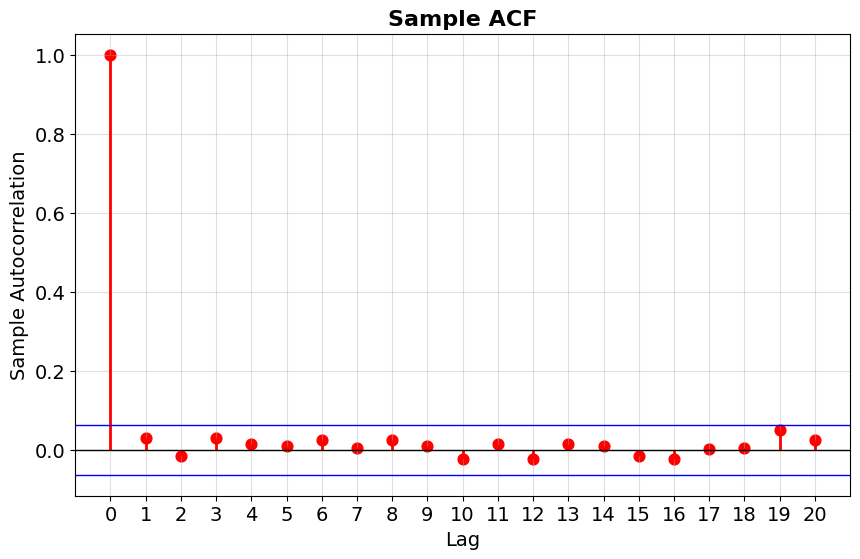

In [32]:
correlogram_plotting('acf', df_train_d_1, nlags=20, figsize=(10, 6))

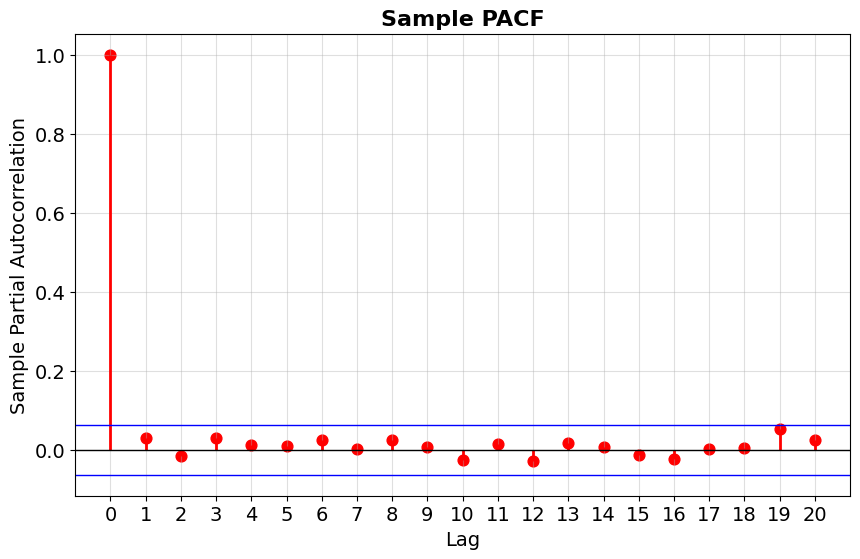

In [36]:
correlogram_plotting('pacf', df_train_d_1, nlags=20, figsize=(10, 6))

**Коррелограммы и критерии Люнга-Бокса и Бокса-Пирса говорят, что остатки являются белым шумом**

In [37]:
acorr_ljungbox(df_train_d_1, lags=20, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.769788,0.380283,0.767367,0.381033
2,1.025395,0.598878,1.021903,0.599925
3,1.805615,0.613714,1.798033,0.615363
4,2.016652,0.732696,2.007743,0.734335
5,2.077325,0.838346,2.067971,0.839662
6,2.676736,0.848187,2.662356,0.849873
7,2.690614,0.912073,2.676103,0.913263
8,3.300124,0.914137,3.279224,0.915633
9,3.397520,0.946432,3.375497,0.947532
10,3.961960,0.949047,3.932837,0.950326


Допустим, мы подобрали параметр d модели ARIMA(p, d, q). Параметры p и q подбираются с помощью ACF, PACF, AIC, BIC, но в настоящей ситуации коррелограммы говорят, что остался белый шум

Будем использовать grid search

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
p_s = list(range(10))
q_s = list(range(5))

order_aic_bic = {'aic': [], 'bic': []}

for q in q_s:
    for p in p_s:
        model = ARIMA(df_train_output, order=(p, 1, q)).fit()
        order_aic_bic['aic'].append((model.aic, (p, 1, q)))
        order_aic_bic['bic'].append((model.bic, (p, 1, q)))

order_df = pd.DataFrame(order_aic_bic)
order_df.sort_values('bic')

In [72]:
%%time
p_s = list(range(10))
q_s = list(range(5))

order_aic_bic = {'aic': [], 'bic': []}

for q in q_s:
    for p in p_s:
        model = ARIMA(df_train_d_1, order=(p, 0, q)).fit()
        order_aic_bic['aic'].append((model.aic, (p, 0, q)))
        order_aic_bic['bic'].append((model.bic, (p, 0, q)))

order_df = pd.DataFrame(order_aic_bic)
order_df.sort_values('bic')

CPU times: user 1min 51s, sys: 1min 25s, total: 3min 16s
Wall time: 1min 51s


,aic,bic
0,"(3260.1673565804404, (0, 0, 0))","(3269.884486650023, (0, 0, 0))"
10,"(3261.3719629811017, (0, 0, 1))","(3275.9476580854757, (0, 0, 1))"
1,"(3261.3999487120773, (1, 0, 0))","(3275.9756438164513, (1, 0, 0))"
11,"(3262.8762110996245, (1, 0, 1))","(3282.31047123879, (1, 0, 1))"
20,"(3263.071784531273, (0, 0, 2))","(3282.5060446704383, (0, 0, 2))"
2,"(3263.1195510970224, (2, 0, 0))","(3282.553811236188, (2, 0, 0))"
3,"(3264.2883336724226, (3, 0, 0))","(3288.5811588463794, (3, 0, 0))"
30,"(3264.3643237806373, (0, 0, 3))","(3288.657148954594, (0, 0, 3))"
12,"(3264.8242862538855, (2, 0, 1))","(3289.1171114278422, (2, 0, 1))"
21,"(3264.8291973695214, (1, 0, 2))","(3289.122022543478, (1, 0, 2))"


Попробуем модели ARIMA(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1)

# Тесты моделей

In [88]:
def model_summarization(order):
    model = ARIMA(df_train_output, order=order)
    results = model.fit()

    print(results.summary())

    model_values = np.array(results.fittedvalues)
    train_values = df_train_output.to_numpy().ravel()

    plt.figure(figsize=(12, 8))
    plt.plot(df_train_output)
    plt.plot(model_values)

    residuals = model_values - train_values
    plotting(residuals, f'residuals ARIMA {order}', (12, 8))
    correlogram_plotting('acf', residuals, 20, (10, 6))
    correlogram_plotting('pacf', residuals, 20, (10, 6))
    return model

                               SARIMAX Results                                
Dep. Variable:                  выход   No. Observations:                  953
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1628.182
Date:                Sun, 24 Mar 2024   AIC                           3258.363
Time:                        20:13:58   BIC                           3263.222
Sample:                             0   HQIC                          3260.214
                                - 953                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.7908      0.041     43.547      0.000       1.710       1.871
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):              1424.29
Prob(Q):                              0.38   Pr

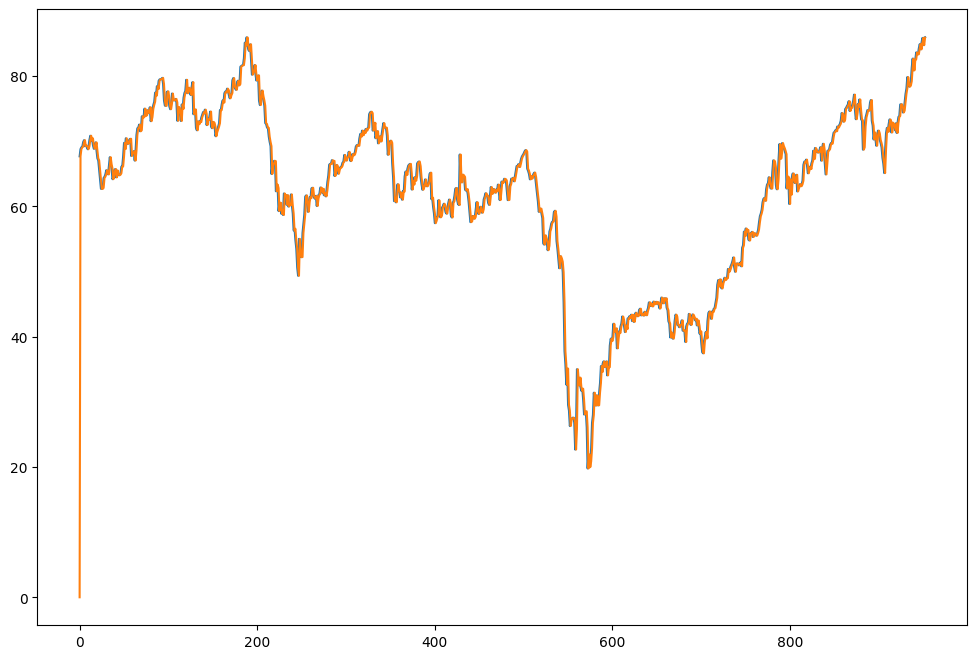

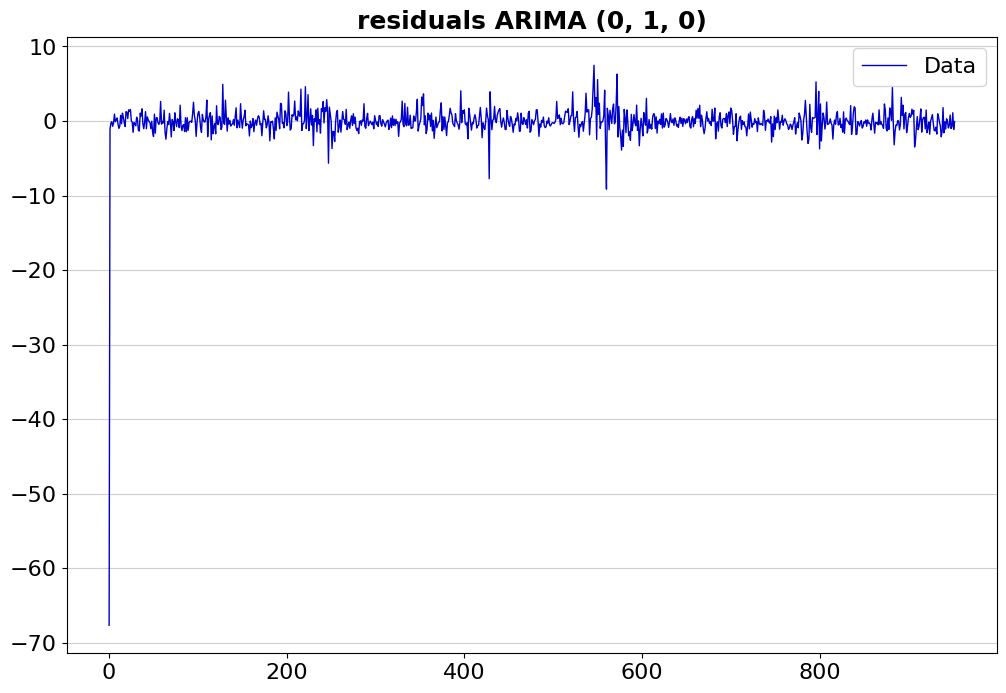

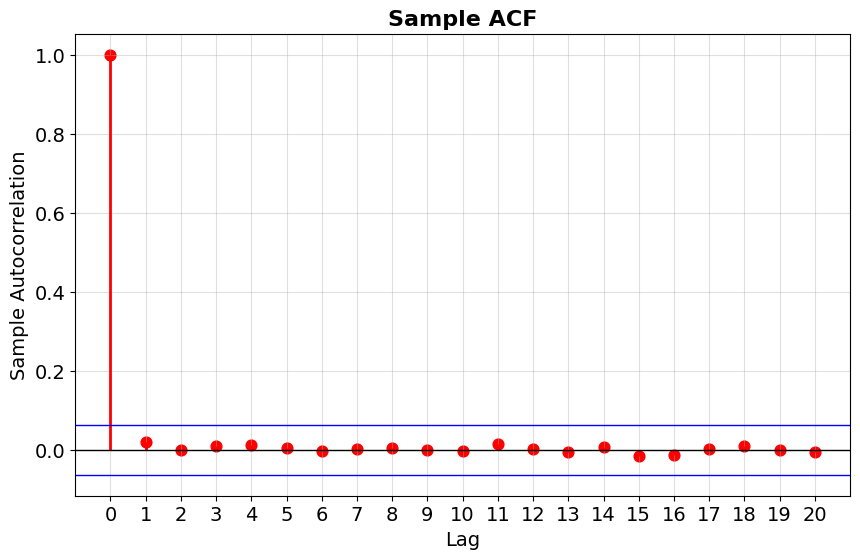

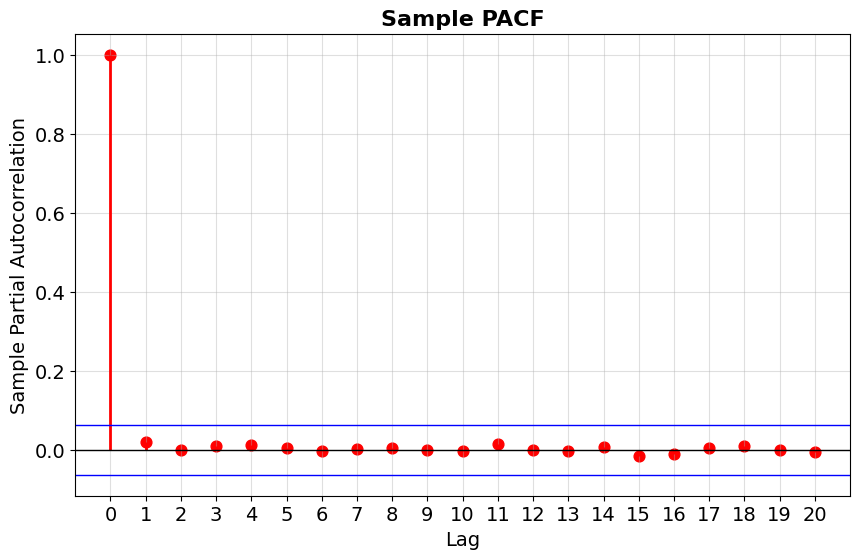

In [89]:
model_0_1_0 = model_summarization((0, 1, 0))

                               SARIMAX Results                                
Dep. Variable:                  выход   No. Observations:                  953
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1627.779
Date:                Sun, 24 Mar 2024   AIC                           3259.558
Time:                        20:14:19   BIC                           3269.275
Sample:                             0   HQIC                          3263.260
                                - 953                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0296      0.022      1.317      0.188      -0.014       0.074
sigma2         1.7893      0.043     41.374      0.000       1.705       1.874
Ljung-Box (L1) (Q):                   0.00   Jarque-

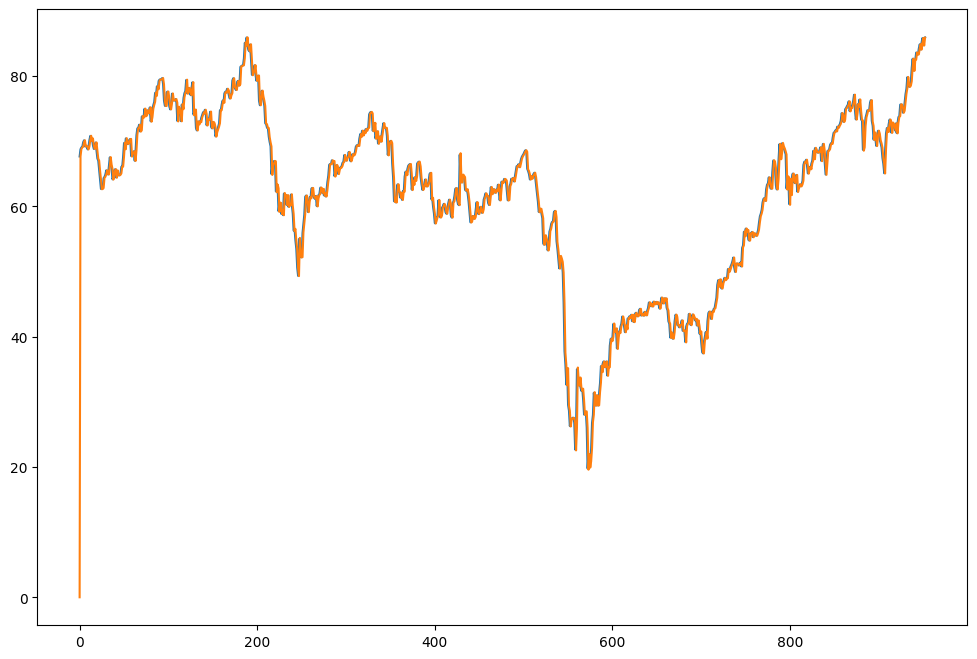

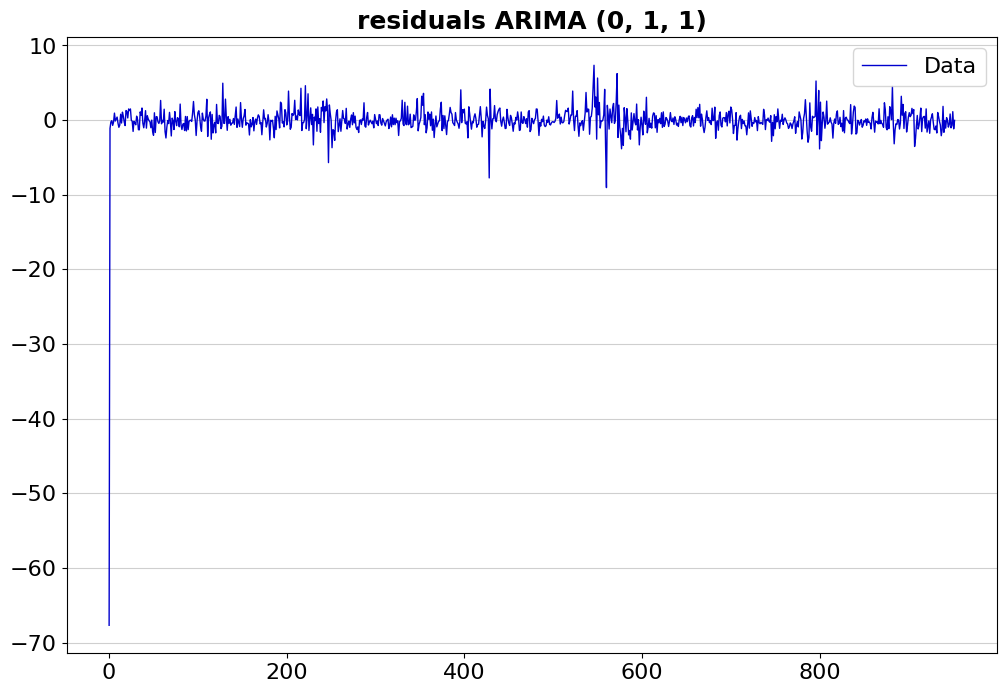

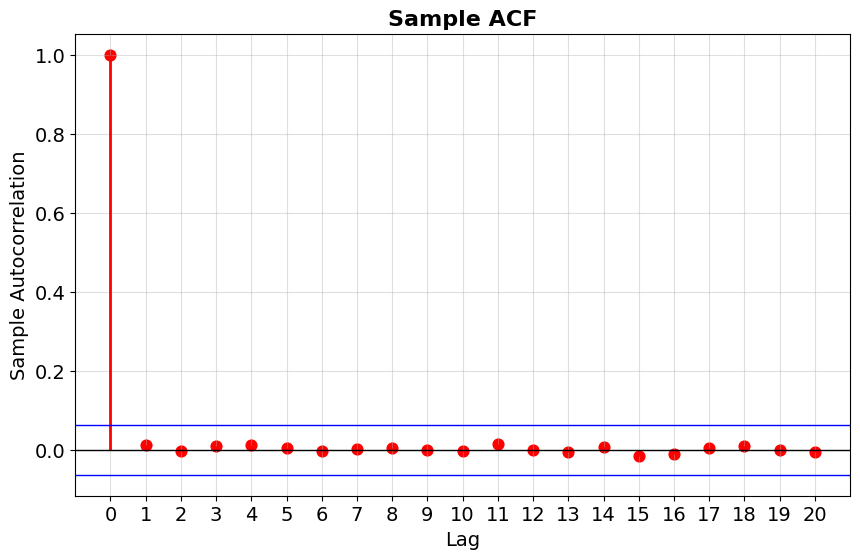

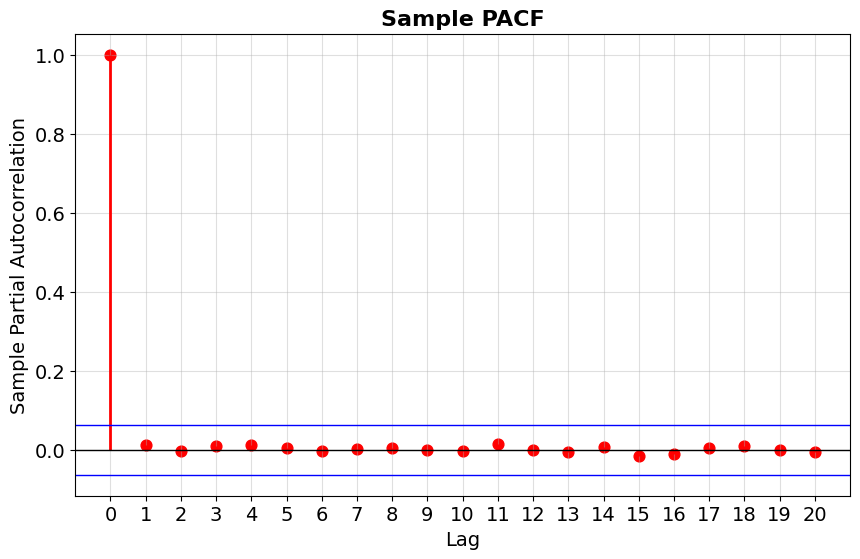

In [90]:
model_0_1_1 = model_summarization((0, 1, 1))

                               SARIMAX Results                                
Dep. Variable:                  выход   No. Observations:                  953
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1627.793
Date:                Sun, 24 Mar 2024   AIC                           3259.586
Time:                        20:14:26   BIC                           3269.303
Sample:                             0   HQIC                          3263.288
                                - 953                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0286      0.022      1.270      0.204      -0.016       0.073
sigma2         1.7893      0.043     41.498      0.000       1.705       1.874
Ljung-Box (L1) (Q):                   0.00   Jarque-

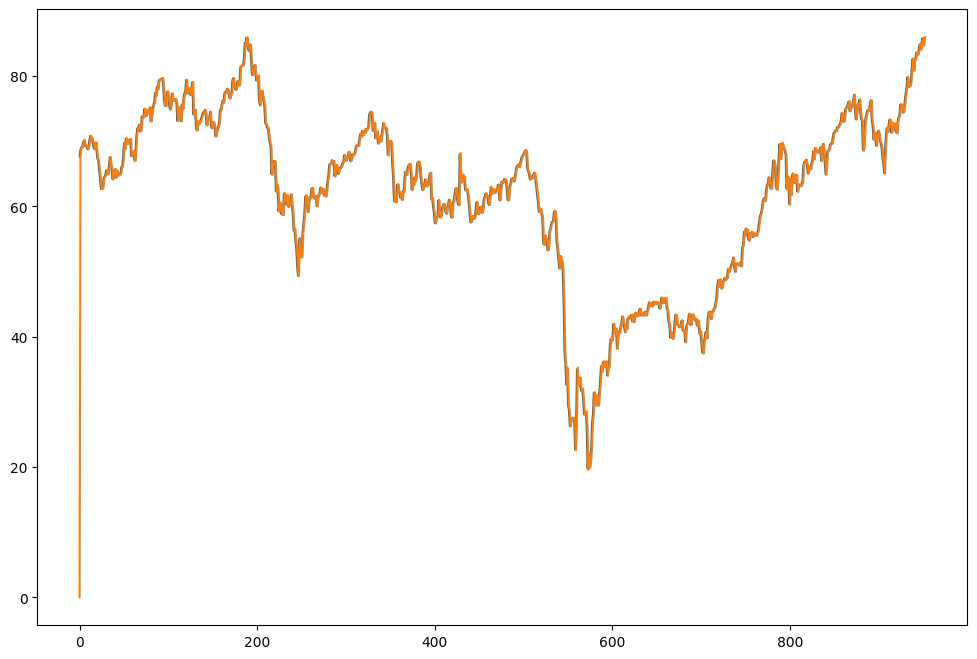

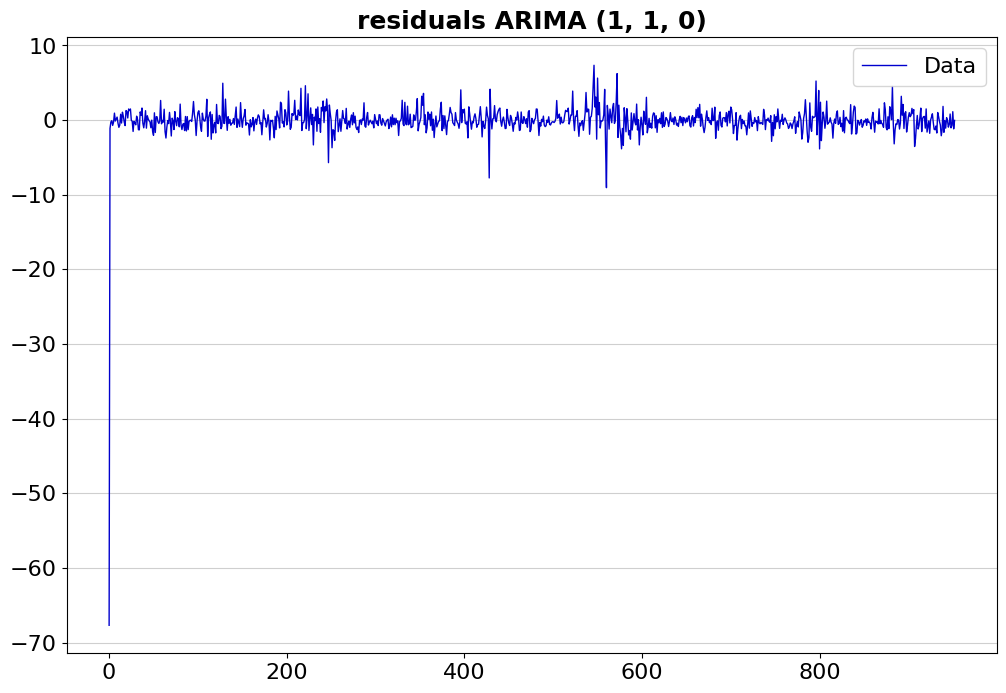

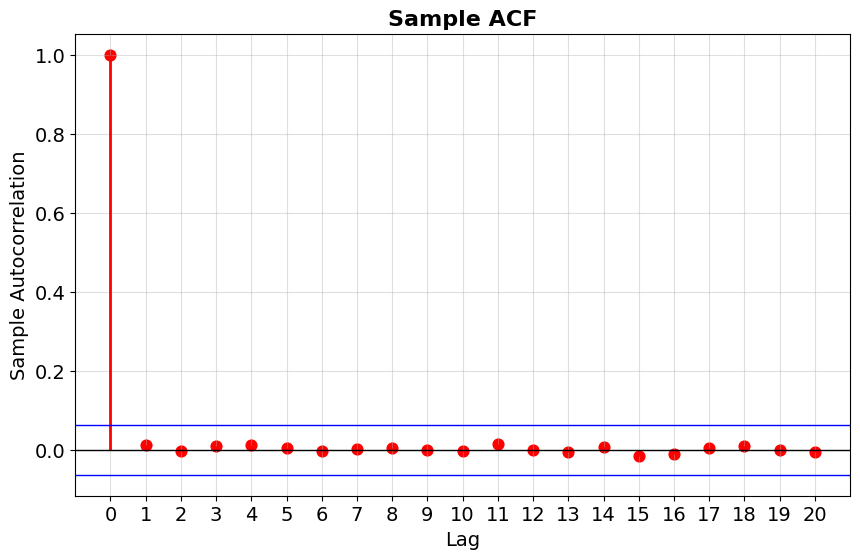

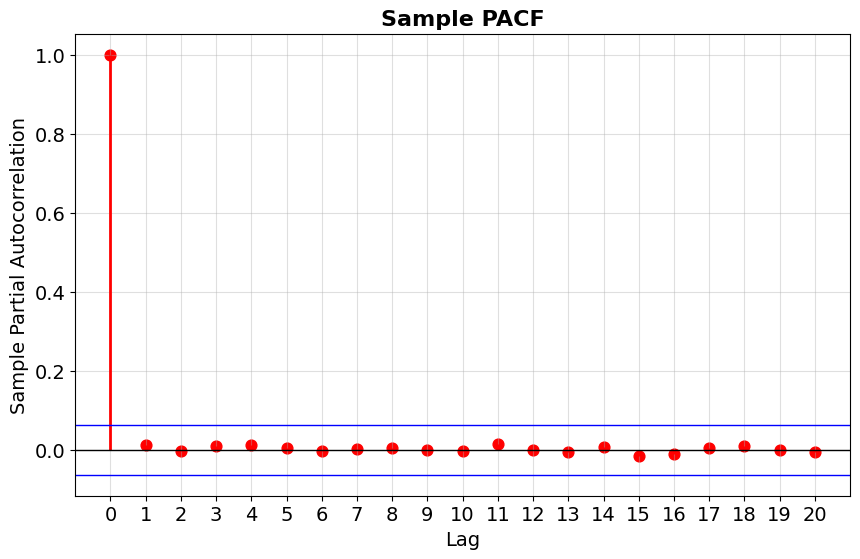

In [91]:
model_1_1_0 = model_summarization((1, 1, 0))

                               SARIMAX Results                                
Dep. Variable:                  выход   No. Observations:                  953
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1627.532
Date:                Sun, 24 Mar 2024   AIC                           3261.064
Time:                        20:14:35   BIC                           3275.640
Sample:                             0   HQIC                          3266.617
                                - 953                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5005      0.507     -0.988      0.323      -1.494       0.493
ma.L1          0.5325      0.498      1.070      0.285      -0.443       1.508
sigma2         1.7884      0.044     40.986      0.0

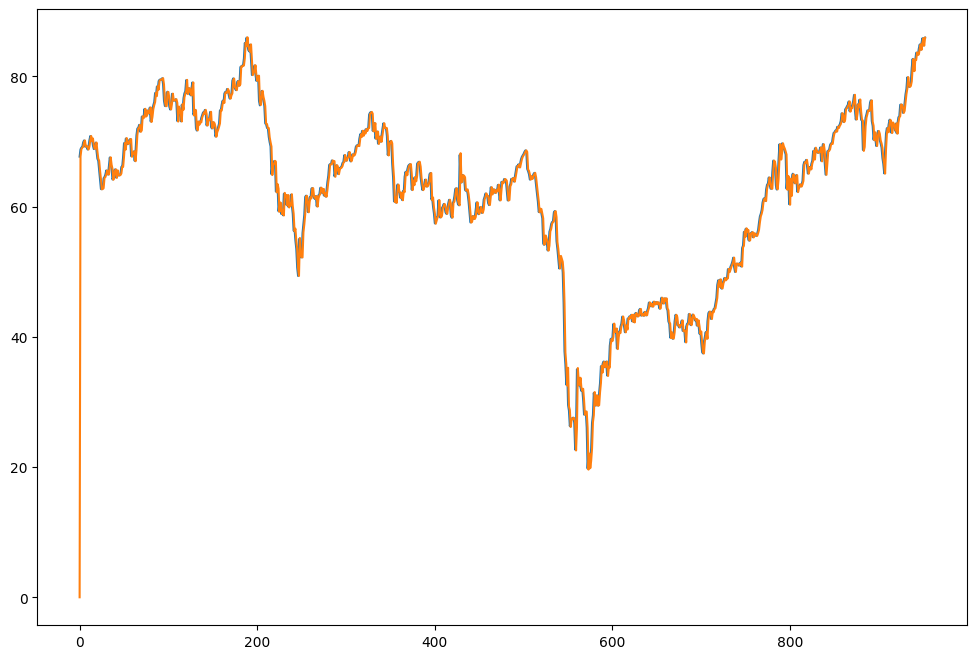

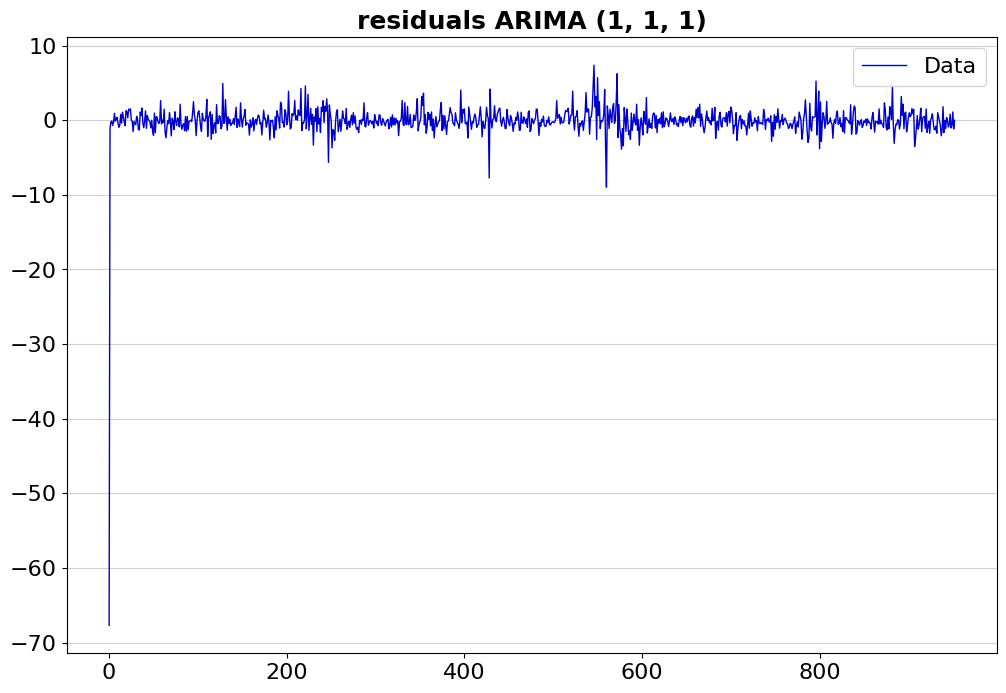

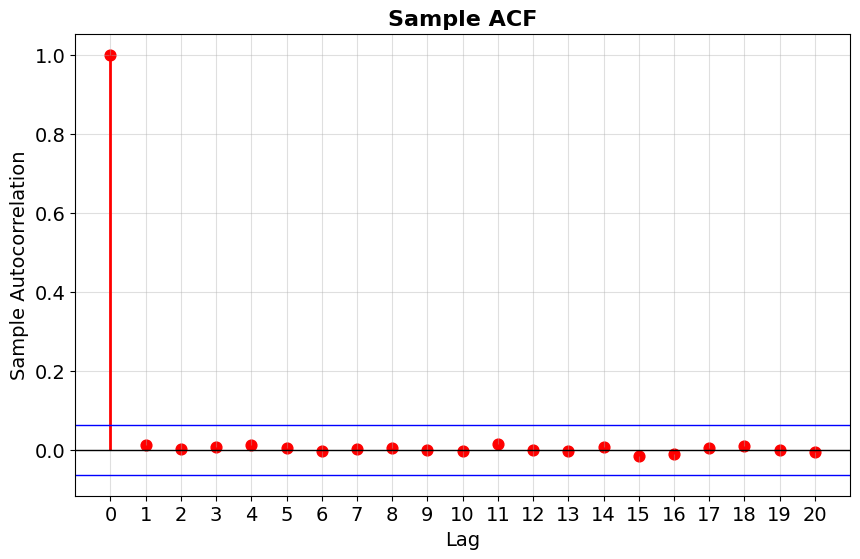

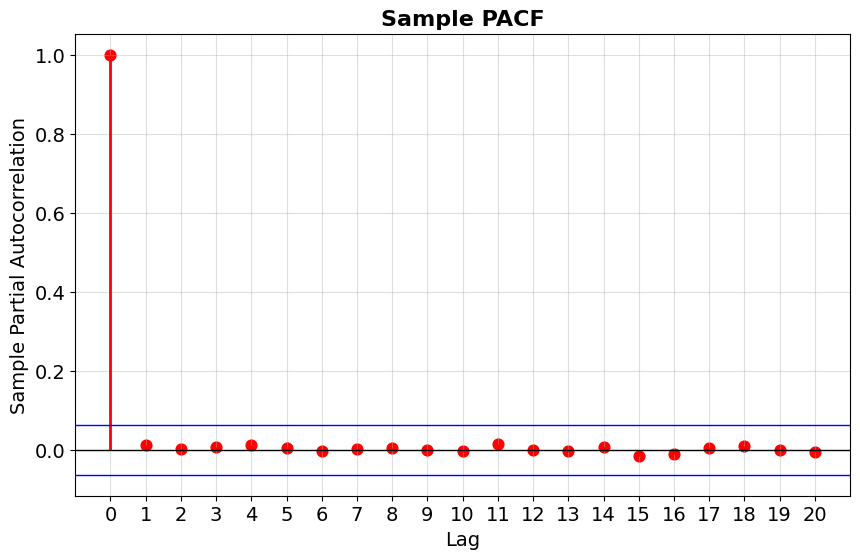

In [92]:
model_1_1_1 = model_summarization((1, 1, 1))

In [132]:
df_val_output.values

array([86.22, 84.13, 84.54, 84.41, 84.59, 84.23, 81.29, 82.66, 83.68,
       84.89, 82.61, 82.62, 82.1 , 82.05, 82.52, 80.57, 81.19, 78.51,
       79.43, 82.58, 82.14, 82.25, 72.36, 73.06, 70.56, 68.75, 70.29,
       69.77, 73.42, 75.14, 76.01, 74.13, 75.43, 74.55, 73.48, 74.43,
       74.81, 73.43, 71.86, 74.16, 75.45, 76.9 , 75.75, 78.69, 79.06,
       79.21, 79.3 , 78.95])

In [135]:
results_0_1_0 = model_0_1_0.fit()
st_pred = results_0_1_0.get_prediction(start=0, dynamic=True)
forecast_values = st_pred.predicted_mean
print(mean_absolute_error(df_train_output, forecast_values))

pred_future = results_0_1_0.get_forecast(steps=48)
print(mean_absolute_error(pred_future.predicted_mean.values, df_val_output.values))

62.03969569779643
7.656666666666664


In [136]:
results_0_1_1 = model_0_1_1.fit()
st_pred = results_0_1_1.get_prediction(start=0, dynamic=False)
forecast_values = st_pred.predicted_mean
mean_absolute_error(df_train_output, forecast_values)

pred_future = results_0_1_1.get_forecast(steps=48)
print(mean_absolute_error(pred_future.predicted_mean.values, df_val_output.values))

7.657667011354618


In [137]:
results_1_1_0 = model_1_1_0.fit()
st_pred = results_1_1_0.get_prediction(start=0, dynamic=False)
forecast_values = st_pred.predicted_mean
mean_absolute_error(df_train_output, forecast_values)

pred_future = results_1_1_0.get_forecast(steps=48)
print(mean_absolute_error(pred_future.predicted_mean.values, df_val_output.values))

7.658641060464895


In [138]:
results_1_1_1 = model_1_1_1.fit()
st_pred = results_1_1_1.get_prediction(start=0, dynamic=False)
forecast_values = st_pred.predicted_mean
mean_absolute_error(df_train_output, forecast_values)

pred_future = results_1_1_1.get_forecast(steps=48)
print(mean_absolute_error(pred_future.predicted_mean.values, df_val_output.values))

7.639744479719222


# Final

In [149]:
data = df['выход'].apply(lambda x: x.replace(',', '.')).astype(float).values
data

array([67.67, 68.78, 69.06, ..., 79.21, 79.3 , 78.95])

In [150]:
model = ARIMA(data, order=(1, 1, 1))
results = model.fit()

In [151]:
pred_future = results.get_forecast(steps=48)

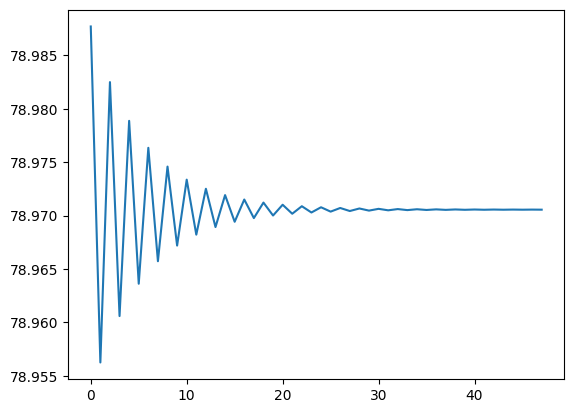

In [153]:
plt.plot(pred_future.predicted_mean)

In [154]:
pred_future.predicted_mean

array([78.98770068, 78.9562419 , 78.98249222, 78.96058802, 78.97886566,
       78.96361415, 78.97634055, 78.96572119, 78.97458236, 78.96718829,
       78.97335816, 78.9682098 , 78.97250578, 78.96892106, 78.97191227,
       78.9694163 , 78.97149903, 78.96976113, 78.97121129, 78.97000122,
       78.97101095, 78.9701684 , 78.97087145, 78.9702848 , 78.97077432,
       78.97036585, 78.97070669, 78.97042228, 78.97065961, 78.97046157,
       78.97062682, 78.97048893, 78.97060399, 78.97050798, 78.97058809,
       78.97052125, 78.97057703, 78.97053048, 78.97056932, 78.97053691,
       78.97056395, 78.97054139, 78.97056022, 78.97054451, 78.97055762,
       78.97054668, 78.97055581, 78.97054819])

In [163]:
bin_data = df['направление'].apply(lambda x: 1 if x == 'л' else 0).values
bin_data

array([0, 1, 0, ..., 0, 0, 0])

In [166]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(bin_data, order=(1, 1, 1), distribution='binomial')
result = model.fit()

forecast = result.get_forecast(steps=48)
forecast_values = np.round(forecast.predicted_mean).astype(int)

forecast_values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])